In [ ]:
!pip install --force-reinstall numpy==1.24.3
!pip install rdkit==2023.9.4 #Reinstall rdkit


In [ ]:
# ✅ Install RDKit for SMILES-based descriptor generation

# ✅ Import libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from tqdm.notebook import tqdm

# ✅ Load your dataset
# Replace with your own CSV or DataFrame
# Example:
df = pd.read_csv('/content/CDK9.csv')

# If already loaded, make sure 'Smiles' exists
# Let's simulate if you're testing:
#df = pd.DataFrame({'Smiles': ['CCO', 'CC(=O)OC1=CC=CC=C1C(=O)O'], 'DC50 (nM)': [120, 95]})

# ✅ Get list of descriptor names
descriptor_names = [desc[0] for desc in Descriptors._descList]

# ✅ Initialize descriptor calculator
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

# ✅ Function to convert a SMILES string into a list of descriptor values
def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(calc.CalcDescriptors(mol))
    else:
        return [None] * len(descriptor_names)

# ✅ Apply to entire SMILES column
tqdm.pandas()  # for progress bar
descriptor_matrix = df['Smiles'].progress_apply(smiles_to_descriptors)

# ✅ Convert to DataFrame
descriptor_df = pd.DataFrame(descriptor_matrix.tolist(), columns=descriptor_names)

# ✅ Merge with original DataFrame (optional: drop original SMILES column)
df = df.drop(columns=['Smiles'])  # optional
df_final = pd.concat([df.reset_index(drop=True), descriptor_df.reset_index(drop=True)], axis=1)

# ✅ Show final result
df_final.head()


In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Replace with your actual file path
df = pd.read_csv(r'D:\Kavya coding\protac\CDK9_RDkit.csv')

# Drop columns that are completely zero
df = df.loc[:, df.isnull().sum() <= 140]


# Train Random Forest on full data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importances
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


# List of important features from the plot (manual selection based on your image)
important_features = ['DC50 (nM)',
    'MinAbsEStateIndex', 'PEOE_VSA7', 'VSA_EState5', 'BCUT2D_LOGPHI',
    'EState_VSA3', 'Chi2v', 'SlogP_VSA5', 'SlogP_VSA2', 'LabuteASA',
    'VSA_EState10', 'MinEStateIndex', 'NumHAcceptors', 'EState_VSA1',
    'EState_VSA5', 'FpDensityMorgan3', 'Rotatable Bond Count',
    'BCUT2D_MRLOW', 'Kappa3', 'VSA_EState2', 'Chi4n', 'VSA_EState3',
    'VSA_EState7', 'SMR_VSA5', 'MolMR', 'MinPartialCharge', 'Chi3n',
    'MolWt', 'Chi0n', 'Molecular Weight'
]

df = df[important_features]
df.to_csv(r'D:\Kavya coding\protac\CDK9_selected_features.csv', index=False)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Log transformation to reduce skewness
df['DC50 (nM)'] = np.log1p(df['DC50 (nM)'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['DC50 (nM)'], kde=True)
plt.title("Log-Transformed Distribution of DC50 (nM)")
plt.xlabel("DC50 (nM) - Log-transformed")
plt.ylabel("Frequency")
plt.show()


print(df.head())

# Only use non-null DC50 values for training
df_non_null = df[df['DC50 (nM)'].notnull()]
df_null = df[df['DC50 (nM)'].isnull()]  # If you want to predict these later

X = df_non_null.drop(columns=['DC50 (nM)'])
y = df_non_null['DC50 (nM)']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test_scaled)

print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


Saving CDK9_selected_features.csv to CDK9_selected_features.csv


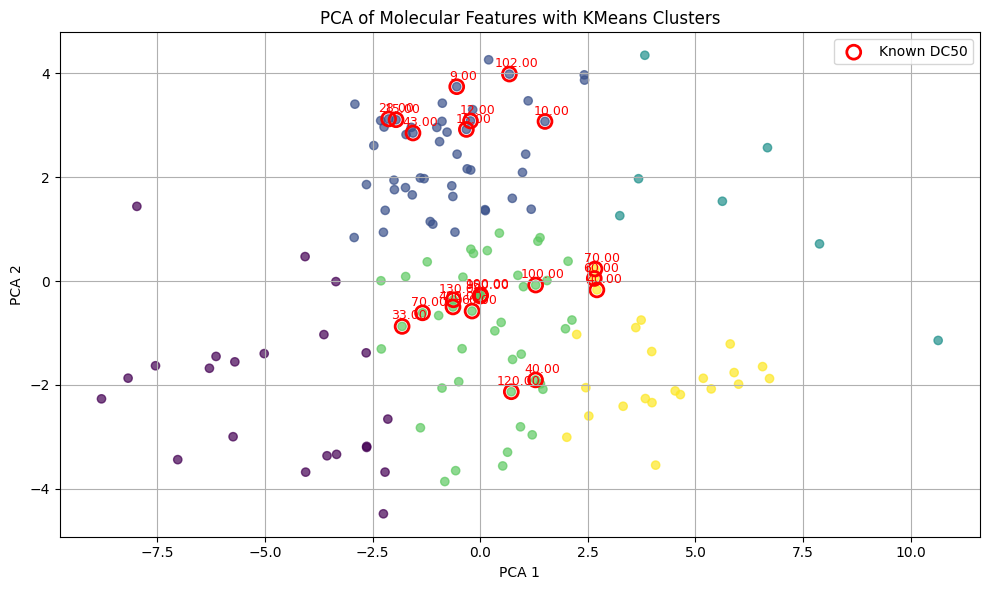

<Figure size 800x500 with 0 Axes>

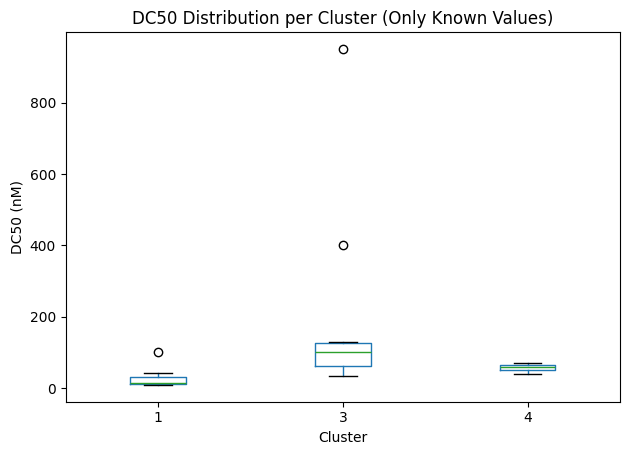

Clusters with known DC50 values: [1 3 4]

Lowest DC50 compound per cluster (only known values):
     Cluster  DC50 (nM)
144        1        9.0
45         3       33.0
120        4       40.0


In [ ]:
# --- Step 0: Upload CSV in Colab ---
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- Step 1: Load the data ---
filename = list(uploaded.keys())[0]  # Use the uploaded file name
df = pd.read_csv(io.BytesIO(uploaded['CDK9_selected_features.csv']))

# --- Step 2: Clean the DC50 column ---
df['DC50 (nM)'] = df['DC50 (nM)'].replace({
    '100/140': 120,
    '30/50': 40
})
df['DC50 (nM)'] = pd.to_numeric(df['DC50 (nM)'], errors='coerce')

# --- Step 3: Drop DC50 for unsupervised analysis ---
features = df.drop(columns=['DC50 (nM)'])

# --- Step 4: Scale the features ---
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- Step 5: Perform PCA to reduce to 2 components ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# --- Step 6: KMeans clustering (5 clusters) ---
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Adding PCA and Cluster results to the dataframe
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
df['Cluster'] = clusters

# --- Step 7: Plot PCA scatter with clusters ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=clusters, cmap='viridis', alpha=0.7)

# Highlight compounds with known DC50 values
dc50_known = ~df['DC50 (nM)'].isna()
plt.scatter(df.loc[dc50_known, 'PCA1'], df.loc[dc50_known, 'PCA2'],
            facecolors='none', edgecolors='red', linewidths=2, s=100, label='Known DC50')

# Annotate known DC50 values
for i in df.index:
    if pd.notna(df.loc[i, 'DC50 (nM)']):
        plt.annotate(f'{df.loc[i, "DC50 (nM)"]:.2f}',
                     (df.loc[i, 'PCA1'], df.loc[i, 'PCA2']),
                     textcoords="offset points", xytext=(5, 5),
                     ha='center', fontsize=9, color='red')

plt.title("PCA of Molecular Features with KMeans Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 8: Optional - Analyze DC50 per cluster ---
known_dc50_df = df[df['DC50 (nM)'].notna()]
if not known_dc50_df.empty:
    plt.figure(figsize=(8, 5))
    known_dc50_df.boxplot(column='DC50 (nM)', by='Cluster', grid=False)
    plt.title('DC50 Distribution per Cluster (Only Known Values)')
    plt.suptitle("")
    plt.xlabel("Cluster")
    plt.ylabel("DC50 (nM)")
    plt.tight_layout()
    plt.show()
else:
    print("No known DC50 values available for boxplot.")

# Show clusters with known DC50 values
valid_dc50_df = df[df['DC50 (nM)'].notna()]
print("Clusters with known DC50 values:", valid_dc50_df['Cluster'].unique())

# Find compound with lowest DC50 per cluster
lowest_dc50_per_cluster = valid_dc50_df.loc[
    valid_dc50_df.groupby('Cluster')['DC50 (nM)'].idxmin()
]
if not lowest_dc50_per_cluster.empty:
    print("\nLowest DC50 compound per cluster (only known values):")
    print(lowest_dc50_per_cluster[['Cluster', 'DC50 (nM)']])
else:
    print("No clusters with known DC50 values found.")


In [ ]:
print(df.loc[144])  # See if DC50 is really NaN
print(valid_dc50_df.loc[144])  # See if 144 is in the filtered valid dataframe


DC50 (nM)                 9.000000
MinAbsEStateIndex         0.028082
PEOE_VSA7                62.200204
VSA_EState5               2.736393
BCUT2D_LOGPHI             2.389562
EState_VSA3             111.269765
Chi2v                    17.665220
SlogP_VSA5               57.248099
SlogP_VSA2              132.925600
LabuteASA               347.305233
VSA_EState10              3.022807
MinEStateIndex           -0.385064
NumHAcceptors            14.000000
EState_VSA1               0.000000
EState_VSA5              28.388736
FpDensityMorgan3          2.362069
Rotatable Bond Count     15.000000
BCUT2D_MRLOW             -0.138953
Kappa3                   11.481831
VSA_EState2              67.242866
Chi4n                     6.793027
VSA_EState3               3.575042
VSA_EState7              11.720631
SMR_VSA5                 55.410700
MolMR                   222.243700
MinPartialCharge         -0.492692
Chi3n                    10.254580
MolWt                   836.050000
Chi0n               

In [ ]:
from scipy.spatial.distance import cdist

# Prepare a list to hold results
similar_compounds = []

# Loop through each most potent compound per cluster
for idx, row in lowest_dc50_per_cluster.iterrows():
    cluster_id = row['Cluster']
    reference_point = np.array([[row['PCA1'], row['PCA2']]])  # The potent compound's PCA location

    # Get all compounds in the same cluster
    cluster_data = df[df['Cluster'] == cluster_id].copy()

    # Calculate Euclidean distances in PCA space
    distances = cdist(reference_point, cluster_data[['PCA1', 'PCA2']].values, metric='euclidean')[0]
    cluster_data['DistanceToPotent'] = distances

    # Find top N most similar compounds
    top_similar = cluster_data.sort_values('DistanceToPotent').head(10)

    # Track which compound it’s similar to
    top_similar['Reference_DC50'] = row['DC50 (nM)']
    top_similar['Reference_Index'] = idx

    similar_compounds.append(top_similar)

# Combine all into one DataFrame
similar_df = pd.concat(similar_compounds, ignore_index=True)

# Show the important columns
print(similar_df[['Reference_Index', 'Reference_DC50', 'Cluster', 'DistanceToPotent', 'DC50 (nM)']])


    Reference_Index  Reference_DC50  Cluster  DistanceToPotent  DC50 (nM)
0               144             9.0        1          0.000000        9.0
1               144             9.0        1          0.460902        NaN
2               144             9.0        1          0.577552        NaN
3               144             9.0        1          0.733604       12.0
4               144             9.0        1          0.750100        NaN
5               144             9.0        1          0.853299       15.0
6               144             9.0        1          0.903220        NaN
7               144             9.0        1          0.904979        NaN
8               144             9.0        1          0.910090        NaN
9               144             9.0        1          1.130527        NaN
10               45            33.0        3          0.000000       33.0
11               45            33.0        3          0.541547       70.0
12               45            33.0   

In [ ]:
# Step 1: Filter only unknown DC50s from similar_df
unknown_potent_like = similar_df[similar_df['DC50 (nM)'].isna()].copy()

# Step 2: Extract their original row indices in df
# Since we didn't reset the index on df before clustering, these should match
unknown_indices = unknown_potent_like.index.tolist()

# Step 3: Get the actual rows from df
likely_potent_candidates = df.loc[unknown_indices]

# Optional: Add PCA and cluster info for context
columns_to_show = ['Cluster', 'PCA1', 'PCA2']
print(likely_potent_candidates[columns_to_show])


    Cluster      PCA1      PCA2
1         3  0.934627 -2.806640
2         3  1.455450 -2.083498
4         1 -2.128825  3.120561
6         0 -7.027684 -3.438634
7         1 -0.538363  2.441941
8         0 -2.650038 -1.382365
9         3  0.163872  0.586024
12        1 -2.472426  2.608687
13        1  0.677149  3.984648
14        0 -8.799427 -2.268218
15        3  0.443923  0.922471
18        3  1.003002 -0.108349
19        3  2.040147  0.381311
23        3 -2.298438 -1.307252
24        0 -8.181195 -1.869898
25        0 -7.544520 -1.631008
26        0 -6.138086 -1.451332
27        0 -6.291846 -1.679279
28        0 -5.701573 -1.556016
29        0 -5.019121 -1.397146


In [ ]:
# Recreate the filtered list of top unknown candidates
likely_potent_indices = [1, 2, 4, 6, 7, 8, 9, 12, 13, 14, 15, 18, 19, 23, 24, 25, 26, 27, 28, 29]
likely_potent_df = df.loc[likely_potent_indices].copy()

# For ranking, compute distance to potent references manually (if not already done)
# But since you already did that in `similar_df`, we can match from there:
unknown_candidates = similar_df[similar_df['DC50 (nM)'].isna()].copy()

# Sort by distance to potent compound (closest = most promising)
top5 = unknown_candidates.sort_values(by='DistanceToPotent').head(7)

# Get their indices to retrieve full feature rows
top5_indices = top5.index.tolist()
top5_features = df.loc[top5_indices]

print("🔬 Top 3 Likely Potent Unknown Compounds:\n")
print(top5_features)



🔬 Top 3 Likely Potent Unknown Compounds:

    DC50 (nM)  MinAbsEStateIndex  PEOE_VSA7  VSA_EState5  BCUT2D_LOGPHI  \
1         NaN           0.023803  70.881702    -3.670593       2.325282   
2         NaN           0.027984  77.302524    -3.663862       2.326782   
12        NaN           0.078404  74.750145    -0.896085       2.336739   
4        28.0           0.075891  49.110691     2.067269       2.388622   
13      102.0           0.020405  75.041847     2.829998       2.390980   
6         NaN           0.009427  43.527933    -4.117656       2.335737   
7         NaN           0.089907  94.663986    -0.528989       2.340402   

    EState_VSA3      Chi2v  SlogP_VSA5  SlogP_VSA2   LabuteASA  ...  \
1     48.819776  16.261850   43.915609  124.807972  368.503963  ...   
2     54.383228  16.686171   49.479061  124.807972  374.868905  ...   
12    30.859954  15.102491  114.959107   91.900449  320.524837  ...   
4     78.483857  16.212389   57.248099  110.284769  334.288603  ...   
13

In [ ]:
# Sorting the top 3 compounds based on DistanceToPotent to find the best
top3_sorted = top3.sort_values(by='DistanceToPotent')

# Print the best compound (smallest distance)
best_compound = top3_sorted.iloc[0]

# Get the original data row for the best compound
best_compound_features = df.loc[best_compound.name]

# Output the sorted top 3 and the best compound
print("🔬 Top 3 Likely Potent Unknown Compounds (sorted by distance to potent):\n")
print(top3_sorted[['Reference_Index', 'DistanceToPotent', 'DC50 (nM)']])

print("\n💡 Best Compound (most similar to potent):\n")
print(best_compound_features)


In [ ]:
df['log_DC50'] = np.log(df['DC50 (nM)'] + 1)  # +1 to avoid log(0) errors


In [ ]:
# Filter out outliers
filtered_df = df[df['DC50 (nM)'] <= 300].copy()

# Drop NaNs
filtered_df = filtered_df.dropna(subset=['DC50 (nM)'])

# Separate features and target
X_filtered = filtered_df.drop(columns=['DC50 (nM)'])  # exclude SMILES or others if needed
y_filtered = filtered_df['DC50 (nM)']


# Drop the influential feature
X_no_minabs = X_filtered.drop(columns=['MinAbsEStateIndex'])

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_minabs)

# Grid search + SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 1, 10],
    'kernel': ['rbf']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_scaled, y_filtered)

print("Best params (no MinAbsEStateIndex):", grid_search.best_params_)
print("MAE:", -grid_search.best_score_)


filtered_df['MinAbsEStateIndex_log'] = np.log1p(filtered_df['MinAbsEStateIndex'])
X_transformed = filtered_df.drop(columns=['DC50 (nM)', 'MinAbsEStateIndex'])  # drop old

X_scaled = scaler.fit_transform(X_transformed)

# Train SVR again
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_scaled, y_filtered)

print("Best params (log transform):", grid_search.best_params_)
print("MAE:", -grid_search.best_score_)




In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
df = df.drop(columns=['MinAbsEStateIndex'])
# --- Step 1: Prepare features and labels ---
# Ensure only rows with known DC50 values are used for training
X = pca_result[df['DC50 (nM)'].notnull()]
y = df['DC50 (nM)'].dropna()

# --- Step 2: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Standardize the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 4: Grid Search to Hypertune SVR ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'epsilon': [0.1, 1, 5, 10],
    'kernel': ['rbf']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_svr = grid_search.best_estimator_

# --- Step 5: Evaluate ---
y_pred = best_svr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f"Best SVR Params: {grid_search.best_params_}")
print(f"SVR MAE: {mae:.2f} nM")


# --- Step 6: Predict for the best compound ---
# Scale the PCA values for the best compound (replace 'best_pca_values' with the actual one if needed)
best_pca_scaled = scaler.transform(best_pca_values)
predicted_dc50_best = best_svr.predict(best_pca_scaled)[0]
print(f"Predicted DC50 for the best compound (Tuned SVR): {predicted_dc50_best:.2f} nM")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='MinAbsEStateIndex', y='DC50 (nM)')
plt.title("DC50 vs MinAbsEStateIndex")
plt.show()


In [ ]:
print("Shape of best_pca_values:", np.array(best_pca_values).shape)
print("Value:", best_pca_values)
